# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes.

In [34]:
options(repr.plot.width=8, repr.plot.height=3)

In [1]:
library(rstan)
options(mc.cores = parallel::detectCores() - 1)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [4]:
?rstan::vb

In [161]:
library(readr)
library(magrittr)
library(dplyr)
library(ggplot2)
library(greta)
library(LaplacesDemon)


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



The goal of this project is to estimate the model:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(0.5, 0.5) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}

Another way to make thie easier:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Log-Norm}(0, .1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
\alpha & \propto 1 \\
x_{vgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left(\alpha +  \beta_{vg} \right) \right) \\
\end{align}

In [79]:
file_path <- file.path('../', 'data_raw', 'read_counts-normalized.tsv')

In [96]:
suppressMessages(
    sirnas <- readr::read_tsv(file_path) %>%
    dplyr::filter(Gene != "Control")
)

In [97]:
genes <- unique(sirnas$Gene)
replicates <- seq(2)
viruses <- 1

In [98]:
sirnas <- sirnas %>% 
    dplyr::select(sgRNA, Gene, LSLCas9_134, LSLCas9_136) %>%
    dplyr::rename(r1 = LSLCas9_134, r2 = LSLCas9_136) %>%
    tidyr::gather("replicate", "counts", -sgRNA, -Gene) %>%
    dplyr::mutate(counts = floor(counts)) %>%
    dplyr::arrange(sgRNA, replicate)

In [99]:
head(sirnas)

sgRNA,Gene,replicate,counts
ACSM3_sg001,ACSM3,r1,8987
ACSM3_sg001,ACSM3,r2,9300
ACSM3_sg002,ACSM3,r1,15742
ACSM3_sg002,ACSM3,r2,15869
ACSM3_sg003,ACSM3,r1,17348
ACSM3_sg003,ACSM3,r2,17373


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


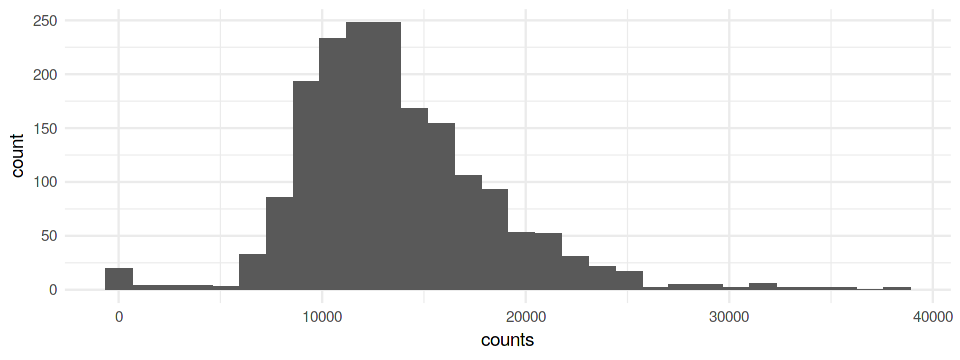

In [92]:
ggplot2::ggplot(sirnas, aes(counts)) +
    geom_histogram() +
    theme_minimal()

Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

In [108]:
dplyr::filter(sirnas, counts < 5000) %>%
        dplyr::group_by(Gene) %>%
        dplyr::summarize(n=n())

Gene,n
B4GALT6,2
DKK4,2
EPHA4,2
EPN2,2
ESPL1,2
F11,2
FEZF2,2
FMO3,2
GNAI3,2
MNAT1,2


## Model 1

We start modelling with a simple hierarchical model to see if this suffices:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Log-Norm}(0, 1) \\
\alpha & \propto 1 \\
x_{vgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left(\alpha +  \beta_{vg} \right) \right) \\
\end{align}

### Simulated data

In [182]:
conditions <- paste0("C", 1:3)
genes   <- paste0("G", 1:3)
sirnas  <- paste0("S", 1:3)
replicates <- paste0("R", 1:3)

In [183]:
factor_table <- expand.grid(conditions, genes, sirnas, replicates) %>%
    magrittr::set_colnames(c("conditions", "genes", "sirnas", "replicates")) %>%
    dplyr::arrange(conditions, genes, sirnas, replicates)

In [186]:
tau_true <- rgamma(1, 1, 1)
gamma_true <- rnorm(length(genes), 0, tau)

In [211]:
beta_true <- MASS::mvrnorm(
    1, 
    rep(gamma_true, each=length(conditions)), 
    diag(tau_true, length(conditions) * length(genes)))
beta_true <- rep(beta_true, each = length(sirnas) * length(replicates))

In [214]:
l_true <- rlnorm(length(conditions) * length(genes) * length(sirnas), 0, 1)
l_true <- rep(l_true, each = length(replicates))

In [216]:
alpha_true <- runif(1, -10, 10)

In [217]:
factor_table$counts <- rpois(
    nrow(factor_table), 
    l_true * exp(alpha_true + beta_true)
)

In [220]:
head(factor_table)

conditions,genes,sirnas,replicates,counts
C1,G1,S1,R1,7
C1,G1,S1,R2,10
C1,G1,S1,R3,7
C1,G1,S2,R1,63
C1,G1,S2,R2,56
C1,G1,S2,R3,49


### Fit

In [327]:
alpha <- variable()
tau <- greta::gamma(1, 1)

In [328]:
gamma <- greta::normal(0, tau, dim = length(genes))

In [329]:
beta <- greta::multivariate_normal(
    t(rep(gamma, each = length(conditions))),
    tau * diag(length(conditions) * length(genes))
)
beta <- rep(beta, each = length(sirnas) * length(replicates))

In [330]:
l <- greta::normal(0, 
                   1, 
                   dim = length(conditions) * length(genes) * length(sirnas))
l <- rep(l, each = length(replicates))

In [331]:
counts <- greta::as_data(factor_table$counts)

In [332]:
distribution(counts) <- greta::poisson(exp(beta + l))

In [333]:
m <- model(beta, l)

In [334]:
samples <- greta::mcmc(m, one_by_one = TRUE)


running 4 chains simultaneously on up to 4 cores

    warmup ====================================== 1000/1000 | eta:  0s | <1% bad
  sampling ====================================== 1000/1000 | eta:  0s          


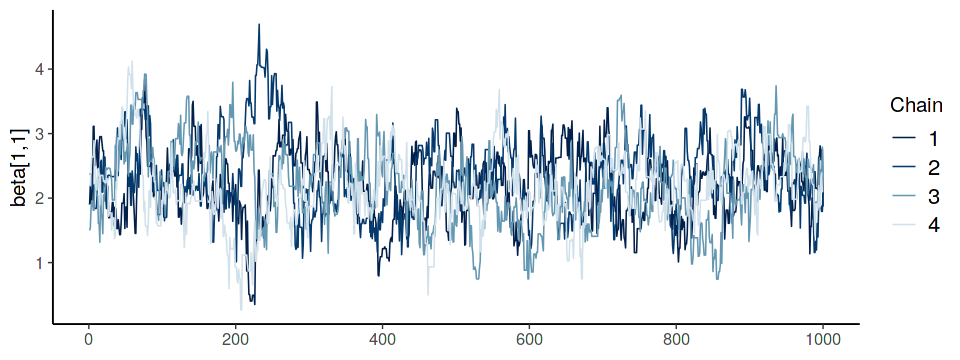

In [336]:
bayesplot::mcmc_trace(samples, pars = "beta[1,1]")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


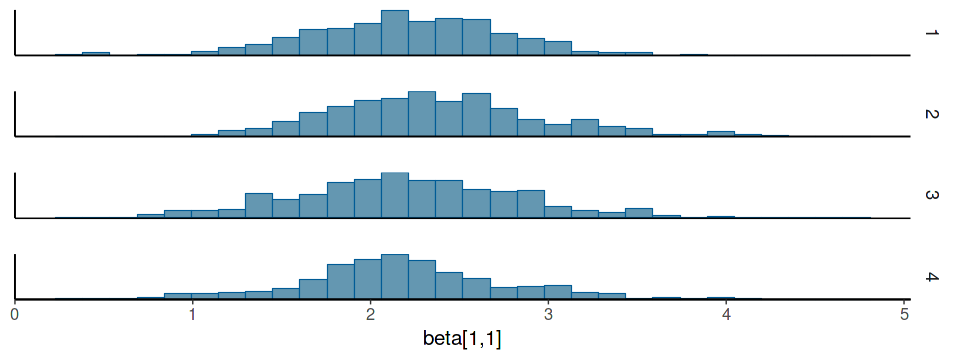

In [338]:
bayesplot::mcmc_hist_by_chain(samples,pars = "beta[1,1]")

In [340]:
beta_true

[1]  1.2976149  1.2976149  1.2976149  1.2976149  1.2976149  1.2976149
 [7]  1.2976149  1.2976149  1.2976149 -0.4741801 -0.4741801 -0.4741801
[13] -0.4741801 -0.4741801 -0.4741801 -0.4741801 -0.4741801 -0.4741801
[19] -3.4144800 -3.4144800 -3.4144800 -3.4144800 -3.4144800 -3.4144800
[25] -3.4144800 -3.4144800 -3.4144800  0.3257221  0.3257221  0.3257221
[31]  0.3257221  0.3257221  0.3257221  0.3257221  0.3257221  0.3257221
[37]  1.6285115  1.6285115  1.6285115  1.6285115  1.6285115  1.6285115
[43]  1.6285115  1.6285115  1.6285115 -2.0334872 -2.0334872 -2.0334872
[49] -2.0334872 -2.0334872 -2.0334872 -2.0334872 -2.0334872 -2.0334872
[55] -0.7406005 -0.7406005 -0.7406005 -0.7406005 -0.7406005 -0.7406005
[61] -0.7406005 -0.7406005 -0.7406005 -1.6201331 -1.6201331 -1.6201331
[67] -1.6201331 -1.6201331 -1.6201331 -1.6201331 -1.6201331 -1.6201331
[73] -1.9891287 -1.9891287 -1.9891287 -1.9891287 -1.9891287 -1.9891287
[79] -1.9891287 -1.9891287 -1.9891287